In [1]:
import pandas_datareader as pdr
import pandas as pd

In [2]:
def get_data():
    temp = pdr.get_data_yahoo('INFY')
    temp.to_csv('C:\Codes\Time-Series\Data\infosys.csv')
    return True
get_data() #To work with data extracted.

True

# EDA

In [3]:
df = pd.read_csv('C:\Codes\Time-Series\Data\infosys.csv')    #Reading the data.
df.index = pd.to_datetime(df['Date'], format = "%Y.%m.%d")   #Changing index to datetime dtype.
df.drop(columns='Date', inplace=True)                        #Dropping the existing date column.
print(df.head())

             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2017-07-13  7.825  7.735  7.775  7.780  20329000.0   6.792685
2017-07-14  7.965  7.750  7.775  7.835  23331800.0   6.840705
2017-07-17  7.870  7.730  7.860  7.820  14512400.0   6.827609
2017-07-18  7.840  7.710  7.800  7.775  12970800.0   6.788320
2017-07-19  7.785  7.675  7.780  7.690  15647400.0   6.714106


In [4]:
print(df.tail())

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2022-07-06  19.020000  18.700001  18.700001  18.930000   8860200.0  18.930000
2022-07-07  19.180000  18.900000  18.990000  19.160000   9675500.0  19.160000
2022-07-08  19.160000  18.760000  19.049999  19.059999  15835100.0  19.059999
2022-07-11  18.590000  18.230000  18.500000  18.459999   7908800.0  18.459999
2022-07-12  18.370001  18.110001  18.190001  18.209999  12463200.0  18.209999


In [5]:
print(df.describe())

              High          Low         Open        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean     13.605711    13.375636    13.489956    13.493617  1.046695e+07   
std       5.506417     5.418305     5.463490     5.465214  6.557974e+06   
min       7.155000     6.760000     6.920000     6.940000  1.320600e+06   
25%       9.371250     9.170000     9.261250     9.270000  6.531225e+06   
50%      10.875000    10.730000    10.820000    10.775000  8.877450e+06   
75%      18.532499    18.172500    18.342500    18.352500  1.249860e+07   
max      26.389999    25.580000    26.150000    26.200001  7.716540e+07   

         Adj Close  
count  1258.000000  
mean     12.863292  
std       5.663839  
min       6.225173  
25%       8.588130  
50%      10.005213  
75%      17.881565  
max      25.910423  


In [6]:
print(df.isnull().any(axis=0))  #No null values.

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool


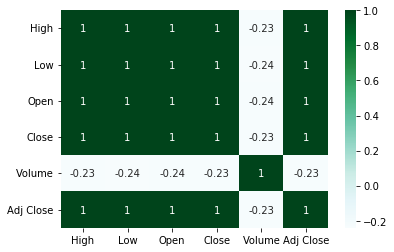

In [8]:
import seaborn as sns
sns.heatmap(df.corr(), cmap = 'BuGn', annot=True)

In [9]:
#We are only going to be working with the close value.
df.drop(columns=['Volume','High','Low','Open','Adj Close'], inplace=True)

In [10]:
df.head()

,Close
Date,
2017-07-13,7.780
2017-07-14,7.835
2017-07-17,7.820
2017-07-18,7.775
2017-07-19,7.690


In [11]:
#Saving it to a different csv file.
df.to_csv('C:\Codes\Time-Series\Data\closeInfosys.csv')

# Data-Preprocessing

In [12]:
closeDF = pd.read_csv('C:\Codes\Time-Series\Data\closeInfosys.csv')
print(closeDF.head())

         Date  Close
0  2017-07-13  7.780
1  2017-07-14  7.835
2  2017-07-17  7.820
3  2017-07-18  7.775
4  2017-07-19  7.690


In [13]:
closeDF.set_index(closeDF['Date'],drop=True, inplace=True)  #Setting the index column as the date column.

In [14]:
closeDF.drop(columns='Date', inplace=True)                  #Dropping the existing date column.

In [15]:
print(closeDF.head())

            Close
Date             
2017-07-13  7.780
2017-07-14  7.835
2017-07-17  7.820
2017-07-18  7.775
2017-07-19  7.690


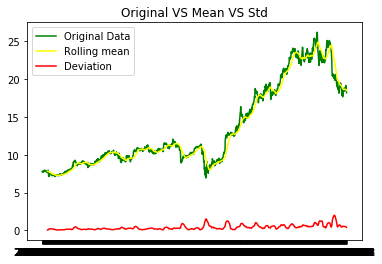

In [16]:
#Getting the moving average and deviation.
data_mean = closeDF['Close'].rolling(window=23).mean()
data_std = closeDF['Close'].rolling(window=23).std()

#Plotting the results.
from matplotlib import pyplot as plt
plt.plot(closeDF['Close'], color='green', label='Original Data')
plt.plot(data_mean, color="yellow", label="Rolling mean")
plt.plot(data_std, color='red', label='Deviation')
plt.legend(loc='best')
plt.title('Original VS Mean VS Std')
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#Normalizing the data.
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(closeDF['Close']).reshape(-1,1))
print(df1.shape)

(1258, 1)


In [18]:
closeDF.dropna(inplace=True) #Dropping all the null values.

In [19]:
def split_data(data): 

    '''
    A function to split the data into  train and validation sets.
    '''
    train_size = int(len(data) * 0.70)
    test_size = int(len(data) - train_size)
    train_data, test_data = data[0:train_size,:],data[train_size:len(df1),:1]
    print(train_size, test_size)
    return train_data, test_data

In [20]:
X,Y = split_data(df1) #Splitting the data into train and validation sets.

880 378


In [21]:
#Saving the numpy arrays in a csv file.
np.savetxt('C:\\Codes\\Time-Series\\Data\\train_data.csv', X)
np.savetxt('C:\\Codes\\Time-Series\\Data\\test_data.csv', Y)

In [22]:
#Reading the data saved earlier.
x = pd.read_csv("C:\\Codes\\Time-Series\\Data\\train_data.csv")  #Train Data.
y = pd.read_csv("C:\\Codes\\Time-Series\\Data\\test_data.csv")   #Test Data.

In [23]:
def dataset_matrix(dataset, timestep):
    '''
    Function to generate a data matrix depending upon the time stamps taken into consideration for the forecasting.
    '''
    X_data, Y_data = [], []
    for i in range(len(dataset)-timestep-1):
        flag_X = dataset.iloc[i:(i+timestep), 0]
        flag_Y = dataset.iloc[(i+timestep),0]
        X_data.append(flag_X)
        Y_data.append(flag_Y)
    return np.array(X_data), np.array(Y_data)

In [24]:
timestep = 23
Xtrain, Ytrain = dataset_matrix(x, timestep)
Xtest, Ytest = dataset_matrix(y, timestep)

In [25]:
print(Xtrain.shape,'\n',Ytrain.shape,'\n',Xtest.shape,'\n',Ytest.shape)

(855, 23) 
 (855,) 
 (353, 23) 
 (353,)


In [26]:
#Reshaping the data to feed it into the LSTM model.
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1) 
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

# Bulding the Model.

In [27]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

#Bulding blocks of the model.
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True, input_shape=(23,1)))
model.add(Dropout(0.3))
model.add(LSTM(50,activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 23, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 23, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
____________________________________________________

In [28]:
from keras.callbacks import CSVLogger, ModelCheckpoint,EarlyStopping  
csv_logger = CSVLogger('training.log', separator = ';')
checkpoint = ModelCheckpoint('lstm_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'val_loss', patience = 20)

In [29]:
#Fitting the model with the dataset at hand.
model.fit(Xtrain, Ytrain, validation_data = (Xtest, Ytest), epochs = 100, batch_size = 64,verbose=1, callbacks=[csv_logger, checkpoint, early])

Epoch 1/100
14/14 [==============================] - 8s 112ms/step - loss: 0.0248 - val_loss: 0.1557

Epoch 00001: val_loss improved from inf to 0.15568, saving model to lstm_model.h5
Epoch 2/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0081 - val_loss: 0.1270

Epoch 00002: val_loss improved from 0.15568 to 0.12700, saving model to lstm_model.h5
Epoch 3/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0035 - val_loss: 0.2030

Epoch 00003: val_loss did not improve from 0.12700
Epoch 4/100
14/14 [==============================] - 1s 54ms/step - loss: 0.0017 - val_loss: 1.1857

Epoch 00004: val_loss did not improve from 0.12700
Epoch 5/100
14/14 [==============================] - 1s 53ms/step - loss: 0.0016 - val_loss: 0.1734

Epoch 00005: val_loss did not improve from 0.12700
Epoch 6/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0013 - val_loss: 0.1613

Epoch 00006: val_loss did not improve from 0.12700
Epoch 7/100
14/14 [==

## Evaluation of the Model.

In [30]:
#Predicting values.
train_predict = model.predict(Xtrain)
test_predict = model.predict(Xtest)

In [31]:
#Converting the normalized predictions to their original form.
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [32]:
from keras.losses import MeanSquaredError
metric = MeanSquaredError(reduction='auto', name='mean_squared_error')
metric(Ytrain, train_predict).numpy()

100.86141

In [33]:
metric(Ytest, test_predict).numpy()

375.91223

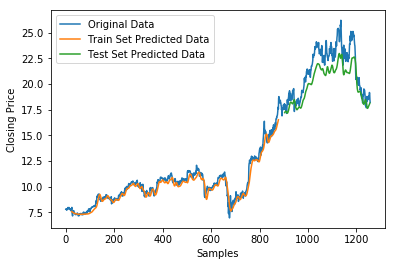

In [34]:
#Evaluation of the model on train and test data.

look_back=24
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label='Original Data')
plt.plot(trainPredictPlot, label='Train Set Predicted Data')
plt.plot(testPredictPlot, label='Test Set Predicted Data')
plt.xlabel('Samples')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [35]:
len(y)

377

In [36]:
x_input=np.array(y[354:]).reshape(1,-1)
x_input.shape

(1, 23)

In [37]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.6344755629506851,
 0.6199376254436337,
 0.5913810721254795,
 0.5664589784261893,
 0.5867081671779131,
 0.5893042804996709,
 0.5571131685310562,
 0.5617860734786229,
 0.6142263741989613,
 0.5908618494611282,
 0.5970924224017495,
 0.6090342465870431,
 0.61370715153461,
 0.5981307686988553,
 0.6059190096325309,
 0.6007268820206131,
 0.6183800564821764,
 0.6090342465870431,
 0.6225337387653913,
 0.6344755629506851,
 0.6292834353387669,
 0.5981307686988553,
 0.5851504991848585]

In [38]:
from numpy import array

lst_output=[]
n_steps=23
i=0
while(i<30):
    
    if(len(temp_input))>23:
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.58191925]
24
1 day input [0.61993763 0.59138107 0.56645898 0.58670817 0.58930428 0.55711317
 0.56178607 0.61422637 0.59086185 0.59709242 0.60903425 0.61370715
 0.59813077 0.60591901 0.60072688 0.61838006 0.60903425 0.62253374
 0.63447556 0.62928344 0.59813077 0.5851505  0.58191925]
1 day output [[0.580294]]
2 day input [0.59138107 0.56645898 0.58670817 0.58930428 0.55711317 0.56178607
 0.61422637 0.59086185 0.59709242 0.60903425 0.61370715 0.59813077
 0.60591901 0.60072688 0.61838006 0.60903425 0.62253374 0.63447556
 0.62928344 0.59813077 0.5851505  0.58191925 0.58029401]
2 day output [[0.5771139]]
3 day input [0.56645898 0.58670817 0.58930428 0.55711317 0.56178607 0.61422637
 0.59086185 0.59709242 0.60903425 0.61370715 0.59813077 0.60591901
 0.60072688 0.61838006 0.60903425 0.62253374 0.63447556 0.62928344
 0.59813077 0.5851505  0.58191925 0.58029401 0.57711393]
3 day output [[0.5726381]]
4 day input [0.58670817 0.58930428 0.55711317 0.56178607 0.61422637 0.59086185
 0.59709242 0.6

In [39]:
day_new=np.arange(1,24)
day_pred=np.arange(24,54)

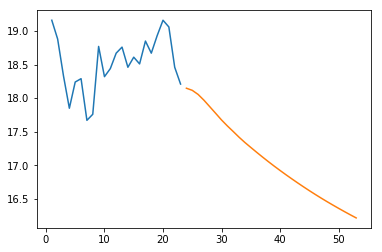

In [40]:
plt.plot(day_new,scaler.inverse_transform(df1[1235:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

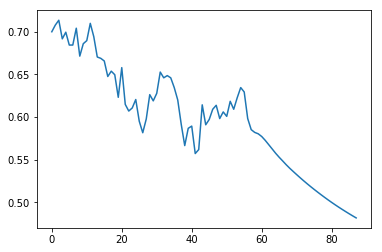

In [41]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

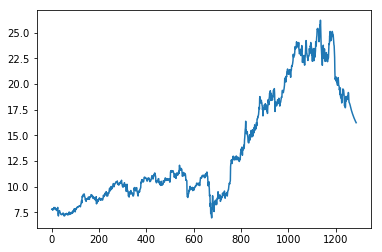

In [42]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)